In [1]:
import torch
print(torch.__version__)

C:\Users\patrick\anaconda3\envs\transformer-3\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


2.6.0+cu126


In [2]:
%matplotlib inline

In [3]:
from pathlib import Path
import requests

In [4]:
##手写数字识别
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)
URL="https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/"
FILENAME="mnist.pkl.gz"
if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)


In [9]:
f

<gzip on 0x29115596040>

In [5]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [8]:
x_train.shape #784 = 28*28*1的图片

(50000, 784)

(50000, 784)
(784,)


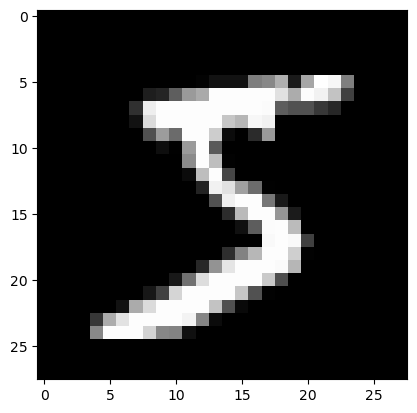

In [6]:
from matplotlib import pyplot
import numpy as np
##x_train[0].reshape((28,28))将一维数据reshape成28 * 28的二维矩阵
##为什么是28*28? 因为x_train数据中就是28*28的图片
pyplot.imshow(x_train[0].reshape((28,28)), cmap="gray")
print(x_train.shape)
print(x_train[0].shape)

In [12]:
type(x_train)

numpy.ndarray

In [14]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid)) ##将ndarray转换成tensor格式
print(type(x_train))
##y_train[:10]
##x_valid_test[0]
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

<class 'torch.Tensor'>
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


C:\Users\patrick\AppData\Local\Temp\ipykernel_26680\4162912750.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))


In [8]:
##torch.nn.functional很多层和函数在这里都会见到
'''
torch.nn.functional中有很多功能，后续会常用的。一般情况下如果模型有可学习的参数，最好用nn.Module，其他情况用nn.functional相对更简单一些。
nn.functional适合测试环境，正式prod环境一般不用。
'''
import torch.nn.functional as F
loss_func = F.cross_entropy  ##要求2个参数(x,y) x为predictor预测值结果,y为标签。cross_entropy交叉熵-损失函数
def model(xb):
    return xb.mm(weights) + bias ##y=wx+b
bs = 64 #一次训练的样本大小，即[64, 784]矩阵大小
xb = x_train[0:bs] #a mini-batch from x
yb = y_train[0:bs]
print(xb.shape)
print(yb.shape)
weights = torch.randn([784, 10], dtype=torch.float, requires_grad = True) ## w [784,10], 784应与输入X的列一致，10应与最后分类的特征数一致）
bias = torch.zeros(10, requires_grad=True) ##bias个数10应与最后分类的特征数一致）
print(loss_func(model(xb), yb))

torch.Size([64, 784])
torch.Size([64])
tensor(17.2182, grad_fn=<NllLossBackward0>)


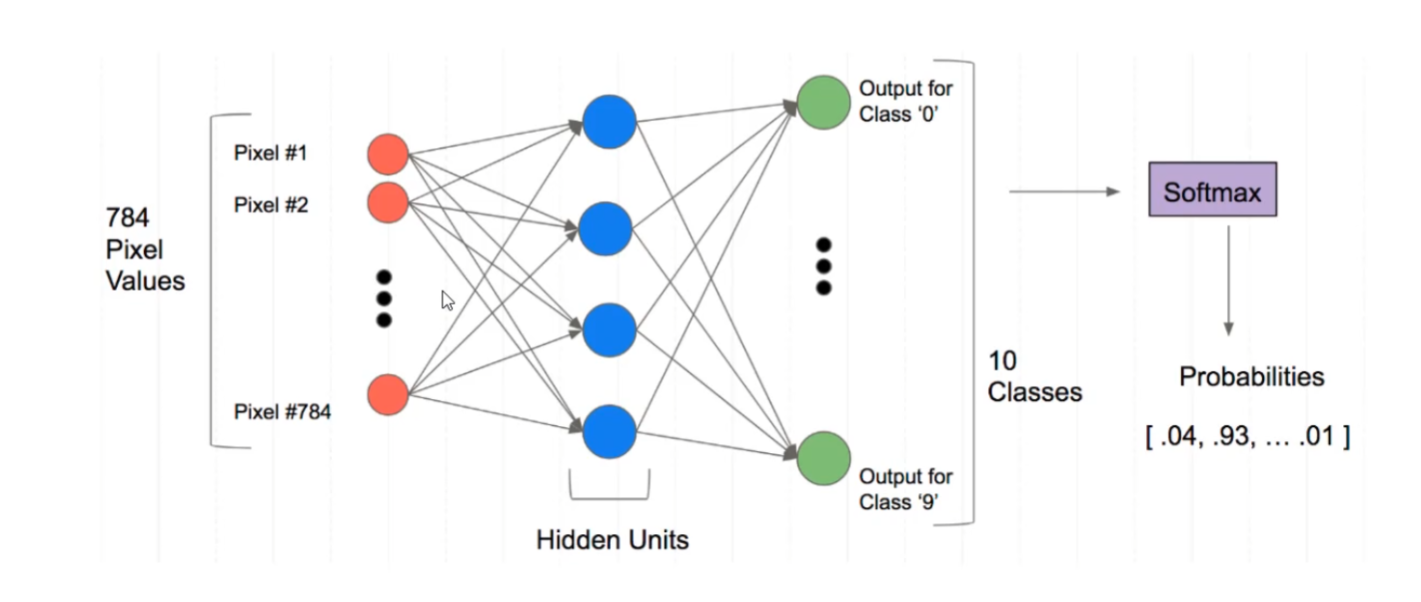

In [9]:
##创建一个model来更简化代码
'''
必须继承nn.Module，且在其构造函数中需调用nn.Module的构造函数
无需写反向传播函数，nn.Module能够利用autograd的设置来实现自动反向传播
Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器
'''
from torch import nn
import torch.nn.functional as F

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784,128) #### 实现wx+b全连接效果。 W = [784,128], b = 128, 代表输入是784个特征（图片的话就是像素），得到128个特征。
        self.hidden2 = nn.Linear(128, 256) #### hidden2层的输入特征就是hidden1的输入-128,因此W = [128， 256]
        #self.hidden3 = nn.Linear(256, 512)
        self.out = nn.Linear(256,10)  ###输出层
        self.dropout = nn.Dropout(0.5) ##dropout是把双刃剑，出发点是为了消除过拟合的影响，值不宜设置的太大, 0.5是百分比，按这个比例去随机删除输入特征，防止过拟合
    '''
    forward中的参数x，是需要我们给定的一个batch的数据,比如传入一个(64, 784)矩阵，
     64 - 指的是batch大小
    784 - 是指输入的总特征数

    (64,784) ->经过hidden1:(64,128) -> 经过hidden2 :(64, 256) -> 经过全连接输入:(64,10)
    '''
    def forward(self, x): ##torch框架需要自己实现前向传播，但反向传播不需要处理，框架会自动处理。
        x = F.relu(self.hidden1(x)) ## relu损失函数算法: sigmoid一样的函数，用于计算损失值
        x = self.dropout(x) ##消除过拟合overfitting
        x = F.relu(self.hidden2(x))
        x = self.dropout(x)
        #x = F.relu(self.hidden3(x))
        x = self.out(x)
        return x

In [12]:
net = Mnist_NN()
#print(net)
#print(net.out)

In [13]:
##查看我们定义好名字里的权重和偏置项
'''
可以看到自动初始化的weight和bias
'''
for name, parameter in net.named_parameters():
    print(name, parameter, parameter.size())

hidden1.weight Parameter containing:
tensor([[ 2.1728e-02, -3.1971e-02, -1.9282e-02,  ..., -2.7069e-02,
          1.3097e-02, -2.8052e-02],
        [-1.9714e-02, -3.3047e-02, -1.2346e-02,  ..., -3.4477e-02,
         -1.2233e-02, -2.3512e-03],
        [ 3.2383e-02,  9.1812e-03,  1.9735e-02,  ...,  1.3060e-02,
          2.9600e-02,  2.3406e-02],
        ...,
        [-2.9376e-02,  4.7836e-05, -1.3186e-02,  ..., -1.7531e-02,
         -2.0280e-02, -2.8166e-02],
        [ 9.6598e-03, -2.5411e-02,  3.5250e-03,  ..., -8.2693e-04,
         -2.3061e-02, -1.7555e-02],
        [ 1.0755e-02,  7.9162e-03, -2.4494e-02,  ...,  1.1913e-02,
         -1.0453e-02, -3.4562e-02]], requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([-2.8941e-02, -3.1081e-03, -1.8421e-02,  1.2319e-02,  1.4188e-03,
         2.5496e-02,  1.3171e-02, -3.4869e-02, -1.5582e-02,  6.9027e-03,
         1.1007e-02,  2.0288e-02,  1.3035e-02,  7.6866e-03,  3.5374e-02,
         1.1583e-02, -1.8869e-02, 

In [14]:
'''
使用TensorDataset和DataLoader来构造数据
－ 为了简化而使用的TensorDataset和DataLoader，正式使用不会用TensorDataset和dataloader
'''
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
train_ds = TensorDataset(x_train, y_train) ##用tensordataset来封装成tensordataset，用于下面data loader中使用
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True) ##DataLoader用于跟GPU传输数据

valid_ds = TensorDataset(x_valid, y_valid) ##用tensordataset来封装成tensordataset，用于下面data loader中使用
train_dl = DataLoader(valid_ds, batch_size=bs * 2) ##DataLoader用于跟GPU传输数据


'''
- 一般在训练模型时加上model.train(),这样就会正常使用batch Normalization 和dropout
- 测试的时候就一般选择model.eval(), 这样就不会使用batch Normalization 和dropout
'''
def get_data(train_ds, valid_ds, bs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True),
           DataLoader(valid_ds, batch_size=bs*2)
           )

In [15]:
'''
前面我们准备好了数据data(train_dl, valid_dl)和model - Mnist_NN

下一步就是什么data和model来进行训练或者eval，通常放在fit方法内
'''
import numpy as np
from torch import optim

'''
steps: 迭代次数，自定义的
model: Mnist_NN
loss_func: F.cross_entropy
opt: 优化器 - 用哪种梯度下降算法
train_dl： train dataloader
valid_dl: validation dataloader
'''
def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    print('fitting')
    for step in range(steps): #epoch概念 - 不是batch
        model.train() ## 指定model的模式，train - 打开训练模式，一般是更新每层的w和b
        for xb, yb in train_dl: ##封装好的dataloader, xb - (64, 784) yb - (64)
            loss_batch(model, loss_func, xb, yb, opt)
        
        model.eval() ## 指定model的模式，eval - 打开验证模式, 不更新w和b
        with torch.no_grad(): ##没有梯度 - 不更新w和b
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums) # 算验证集的结果 - 平均损失
        print('current step:' +str(step), ', 验证集loss:'+str(val_loss))

def get_model():
    model = Mnist_NN()
    #return model, optim.SGD(model.parameters(), lr=0.001) #指定一个优化器，Adam 或者 SGD
    return model, optim.Adam(model.parameters(), lr=0.001) #指定一个优化器，Adam 或者 SGD, lr:学习率

def loss_batch(model, loss_func, xb, yb, opt=None): ##1. 计算loss 2. 更新w和b
    loss = loss_func(model(xb), yb) #计算Loss
    if opt is not None:
        loss.backward() #反向传播 计算出每层的梯度，weight该往哪个方向更新
        opt.step() #更新每层weight
        opt.zero_grad() #zero_grad - 清除当前梯度记录，对梯度置0，而不是累加梯度。下一次梯度计算不受上一次梯度的影响。
    return loss.item(), len(xb)

In [17]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(20, model, loss_func, opt, train_dl, valid_dl)

fitting
current step:0 , 验证集loss:0.18411607325077056
current step:1 , 验证集loss:0.13663566461652518
current step:2 , 验证集loss:0.12013049943186342
current step:3 , 验证集loss:0.11083428809307516
current step:4 , 验证集loss:0.09999112911205739
current step:5 , 验证集loss:0.10318616716489196
current step:6 , 验证集loss:0.09022814821861684
current step:7 , 验证集loss:0.08896339312428608
current step:8 , 验证集loss:0.092813526885584
current step:9 , 验证集loss:0.0846149365533609
current step:10 , 验证集loss:0.08821534962402656
current step:11 , 验证集loss:0.09084119558064267
current step:12 , 验证集loss:0.08051112884869799
current step:13 , 验证集loss:0.08523482230808586
current step:14 , 验证集loss:0.09036759262010455
current step:15 , 验证集loss:0.08562086030924693
current step:16 , 验证集loss:0.08505849627307616
current step:17 , 验证集loss:0.08527625481579452
current step:18 , 验证集loss:0.0782682591716526
current step:19 , 验证集loss:0.07933453778503463


In [20]:
#查看结果 
correct = 0
total = 0
for xb, yb in valid_dl:
    outputs = model(xb)
    #print(outputs)
    print(outputs.shape)
    _, predicted = torch.max(outputs.data, 1) #返回最大值 和 最大值的索引(predicted)
    total += yb.size(0) #总样本数： batch数-yb大小为128个样本，所以total每次+128为总样本数
    correct += (predicted == yb).sum().item() #正确的样本数，.item() 从tensor格式中取值  
print('Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct/ total))

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size